# Differentially abundant taxa in incisors vs molars

Cleaned up notebook

## 1. Install and load required libraries 

In [1]:
# install.packages("remotes")
# remotes::install_github("bryandmartin/CORNCOB")
# install.packages("coda4microbiome")

In [2]:
library(phyloseq, verbose=FALSE)
library(corncob, verbose=FALSE)
library(magrittr, verbose=FALSE)
library(ggplot2, verbose=FALSE)
library(dplyr, verbose=FALSE)
library(coda4microbiome, verbose=FALSE)
library(dplyr, verbose=FALSE)
library(tidyverse, verbose=FALSE)

Warning message:
“package ‘magrittr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning message:
“package ‘forcats’ was built under R version 4.1.3”
Warning message:
“package ‘lubridate’ was built under R version 4.1.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔

## 2. Load phyloseq object

In [3]:
load("../02-diversity/master_phyloseq.RData")
ps.dat
# head(sample_data(ps.dat))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1960 samples ]
sample_data() Sample Data:       [ 1960 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14111 tips and 14109 internal nodes ]

## 3. Collapse data to species level

Only looking at adult teeth, converting premolars to molars and canines to incisors for analyses

In [4]:
# head(tax_table(ps.dat))
ps.dat.glom <- ps.dat %>%
                phyloseq::subset_samples(tooth_type != "unknown" & tooth_age == "adult") %>%
                tax_glom("V8")
sample_data(ps.dat.glom)$tooth_type[sample_data(ps.dat.glom)$tooth_type == "premolar"] <- "molar"
sample_data(ps.dat.glom)$tooth_type[sample_data(ps.dat.glom)$tooth_type == "canine"] <- "incisor"
ps.dat.glom

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 628 taxa and 1083 samples ]
sample_data() Sample Data:       [ 1083 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 628 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 628 tips and 627 internal nodes ]

## 4. Balance of taxa molar vs incisor

### Balance of taxa among all groups

In [5]:
# also do a balance analysis -- which groups of taxa are predictive of molar vs incisor status?
# remove any taxa with fewer than 10 counts and in at least 5% of samples post merging 
glom <- filter_taxa(ps.dat.glom, function(x) sum(x > 10) > (0.05*length(x)), TRUE)
# only include taxa that are healthly 
glom <- subset_samples(glom, aliquot_type == "H-CF")                    
glom

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 272 taxa and 767 samples ]
sample_data() Sample Data:       [ 767 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 272 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 272 tips and 271 internal nodes ]

In [6]:
# pull data
dat <- t(as.data.frame(otu_table(glom)))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing

In [7]:
# get corresponding taxonomy name for each asv
taxa <- as(tax_table(glom), "matrix")
taxadf <- as.data.frame(taxa)
orderdf <- select(taxadf, V8)
orderdf <- orderdf %>%
    rownames_to_column(var = "ASV")
# rename ASV at species level
dat <- as.data.frame(dat)
dat <- dat %>% 
    rownames_to_column(var = "ASV")
dat <- left_join(dat, orderdf, by=c('ASV'='ASV'))  
rownames(dat) <- paste(dat$V8, dat$ASV, sep="_")
dat <- dat[2:(length(dat)-1)] #remove last column
dat <- as.matrix(t(dat))

In [8]:
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
x <- select_if(x, is.numeric)
dim(x)
# define response variable 
y <- as.factor(datmerge$tooth_type)

[1] 767 271

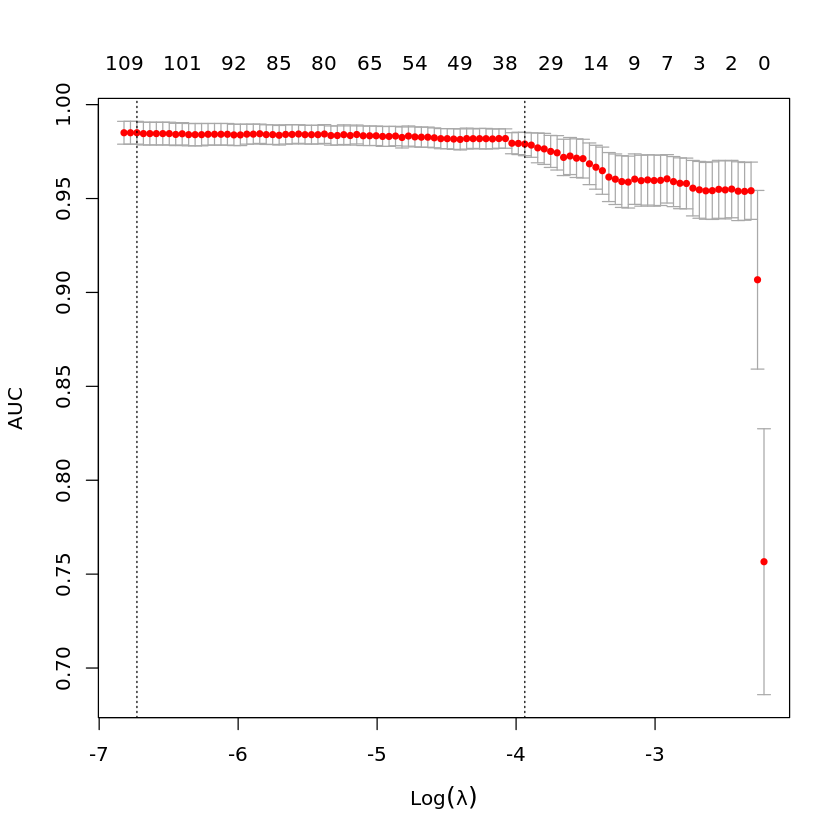

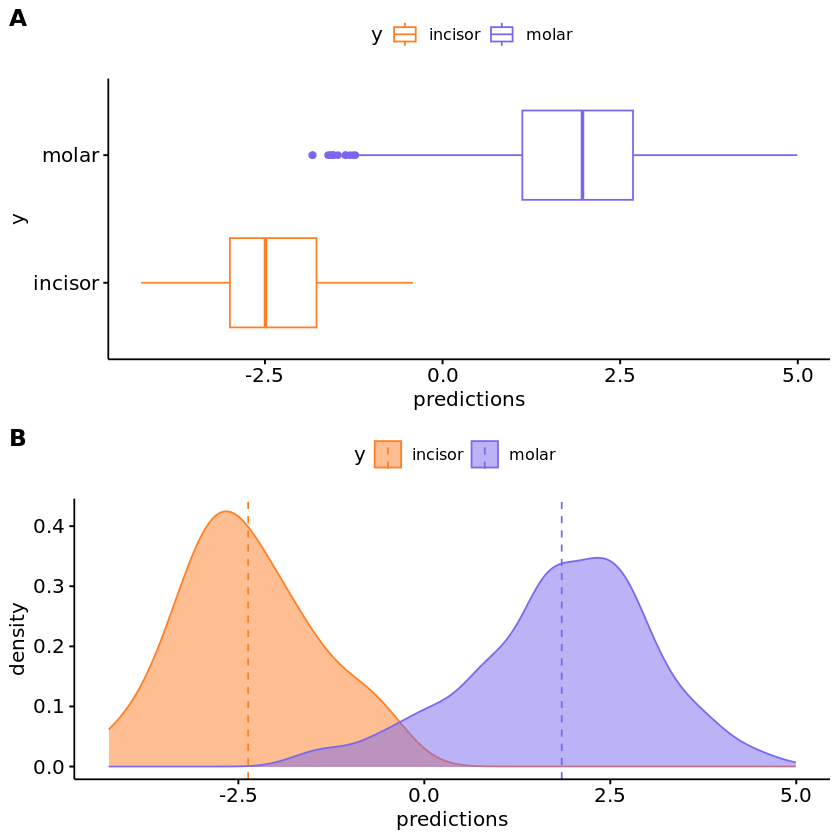

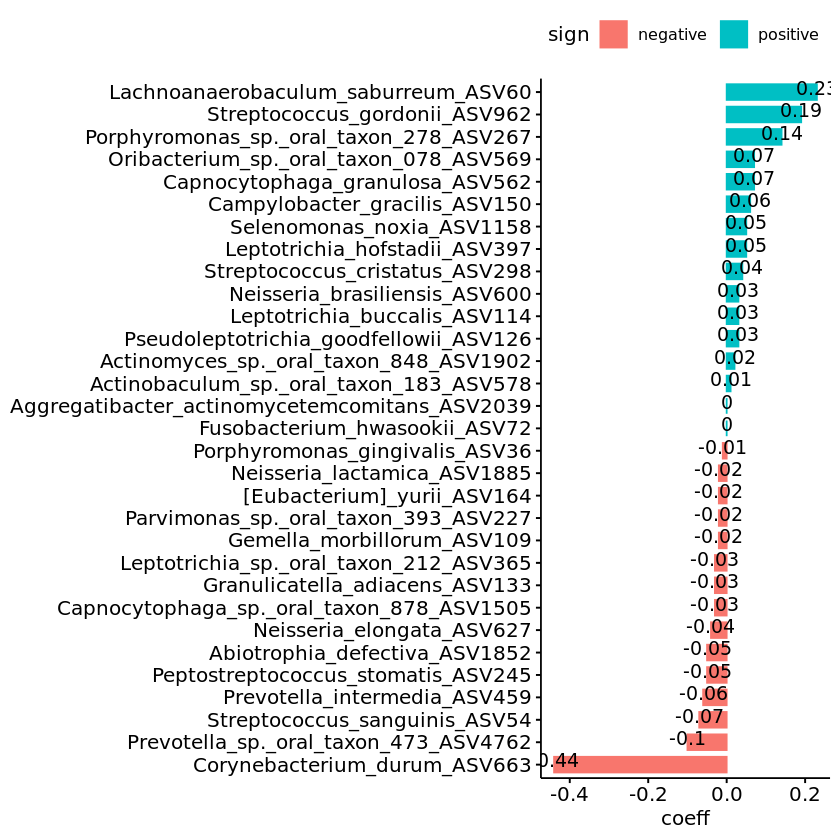

In [9]:
set.seed(852)
bal <- coda_glmnet(x, y)

In [10]:
pdf("balance_incisor_v_molar.pdf")
bal$`predictions plot`
bal$`signature plot`
dev.off()

png 
  2

### HUU 

In [11]:
# by HIV status group
glom <- filter_taxa(ps.dat.glom, function(x) sum(x > 10) > (0.05*length(x)), TRUE)
glom <- subset_samples(glom, hiv_status == "HUU")                    
glom

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 272 taxa and 338 samples ]
sample_data() Sample Data:       [ 338 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 272 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 272 tips and 271 internal nodes ]

In [12]:
# pull data
dat <- t(as.data.frame(otu_table(glom)))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing

In [13]:
# get corresponding taxonomy name for each asv
taxa <- as(tax_table(glom), "matrix")
taxadf <- as.data.frame(taxa)
orderdf <- select(taxadf, V8)
orderdf <- orderdf %>%
    rownames_to_column(var = "ASV")
# rename ASV at species level
dat <- as.data.frame(dat)
dat <- dat %>% 
    rownames_to_column(var = "ASV")
dat <- left_join(dat, orderdf, by=c('ASV'='ASV'))  
rownames(dat) <- paste(dat$V8, dat$ASV, sep="_")
dat <- dat[2:(length(dat)-1)] #remove last column
dat <- as.matrix(t(dat))

In [14]:
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
x <- select_if(x, is.numeric)
dim(x)
# define response variable 
y <- as.factor(datmerge$tooth_type)

[1] 338 271

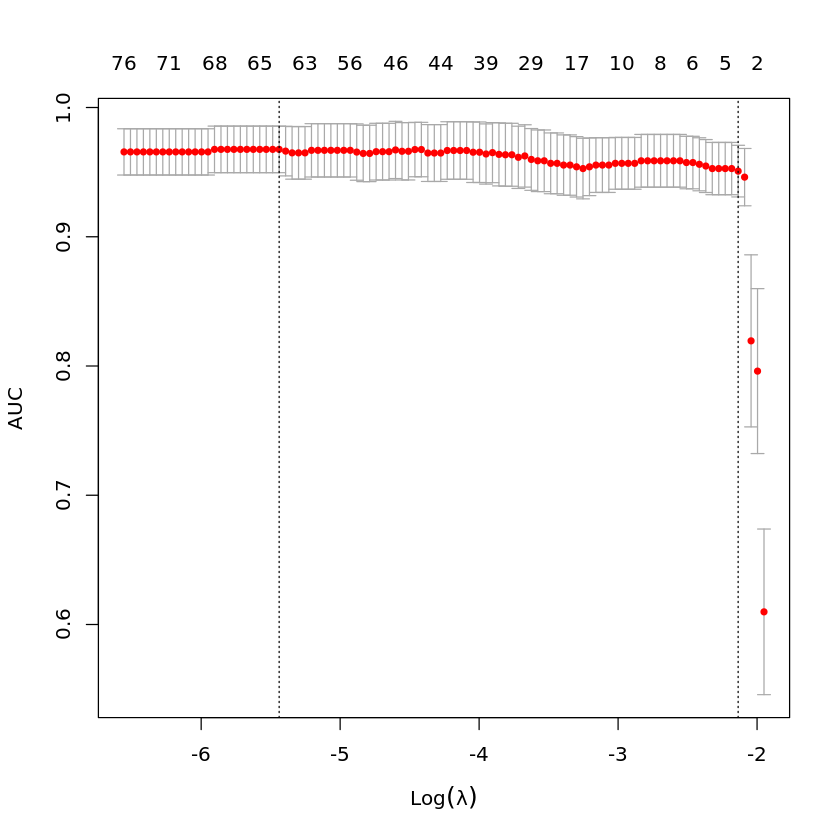

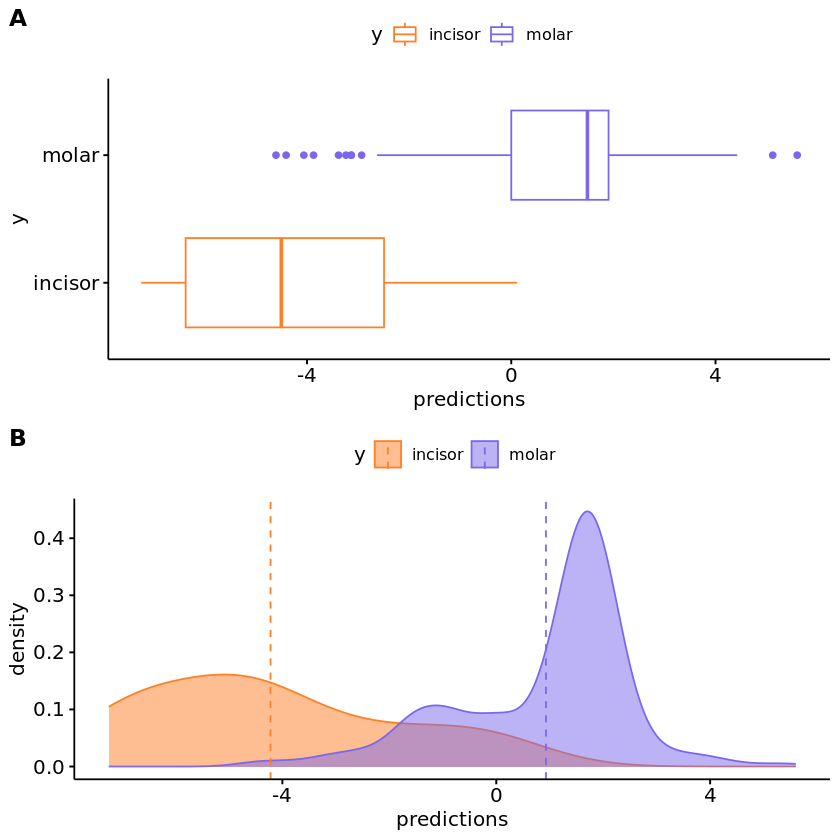

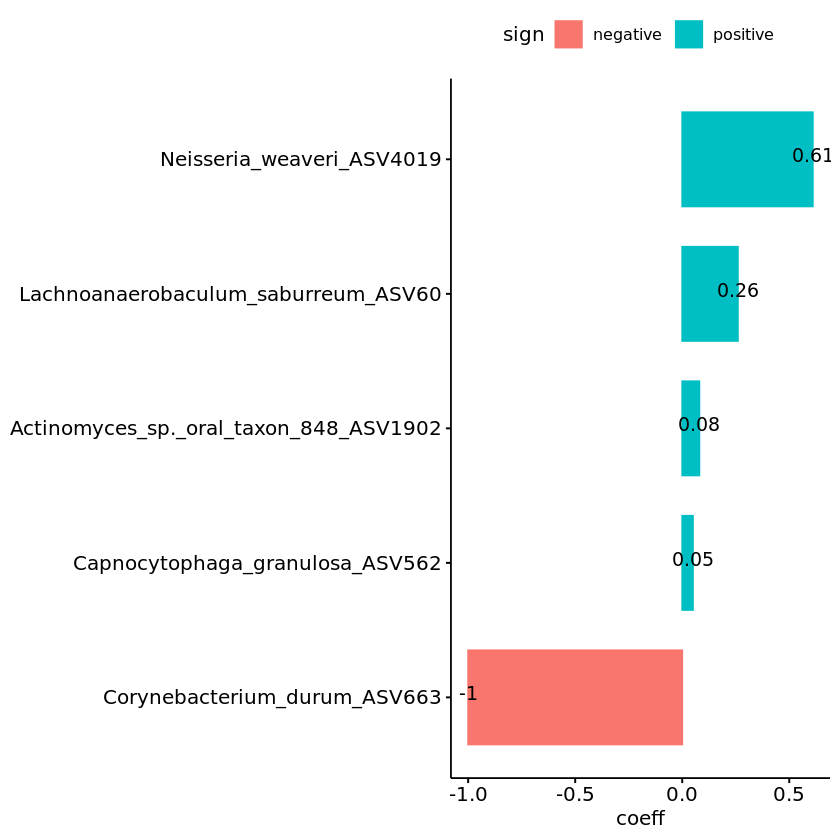

In [15]:
set.seed(852)
bal <- coda_glmnet(x, y)

In [16]:
pdf("balance_incisor_v_molar.HUU.pdf")
bal$`predictions plot`
bal$`signature plot`
dev.off()

png 
  2

### HI

In [17]:
glom <- filter_taxa(ps.dat.glom, function(x) sum(x > 10) > (0.05*length(x)), TRUE)
glom <- subset_samples(glom, hiv_status == "HI")                    
glom

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 272 taxa and 383 samples ]
sample_data() Sample Data:       [ 383 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 272 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 272 tips and 271 internal nodes ]

In [18]:
# pull data
dat <- t(as.data.frame(otu_table(glom)))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing

In [19]:
# get corresponding taxonomy name for each asv
taxa <- as(tax_table(glom), "matrix")
taxadf <- as.data.frame(taxa)
orderdf <- select(taxadf, V8)
orderdf <- orderdf %>%
    rownames_to_column(var = "ASV")
# rename ASV at species level
dat <- as.data.frame(dat)
dat <- dat %>% 
    rownames_to_column(var = "ASV")
dat <- left_join(dat, orderdf, by=c('ASV'='ASV'))  
rownames(dat) <- paste(dat$V8, dat$ASV, sep="_")
dat <- dat[2:(length(dat)-1)] #remove last column
dat <- as.matrix(t(dat))

In [20]:
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
x <- select_if(x, is.numeric)
dim(x)
# define response variable 
y <- as.factor(datmerge$tooth_type)

[1] 383 271

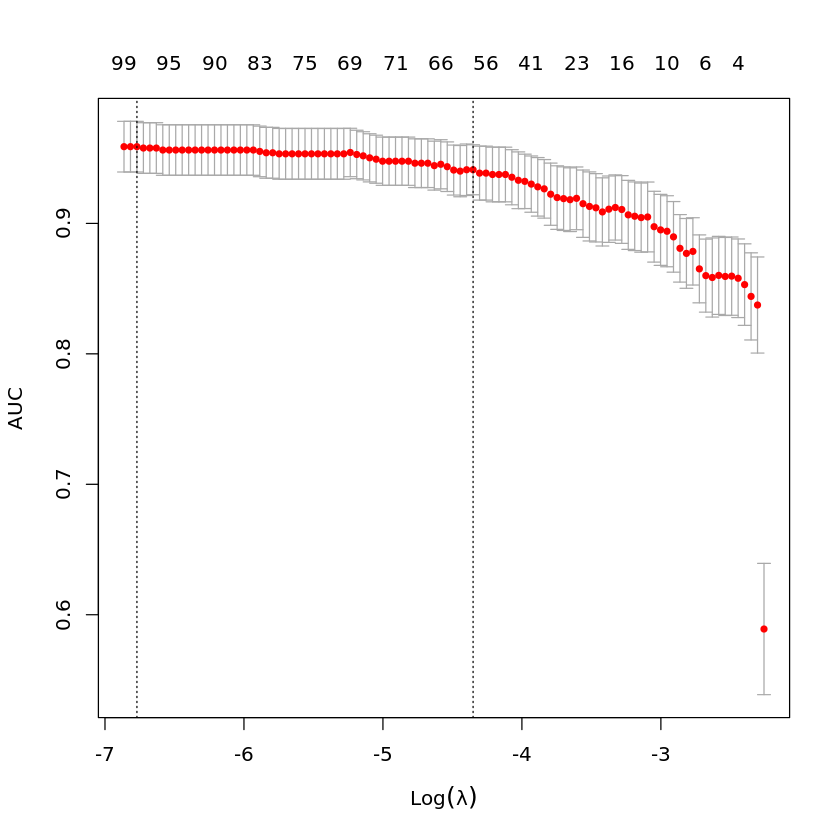

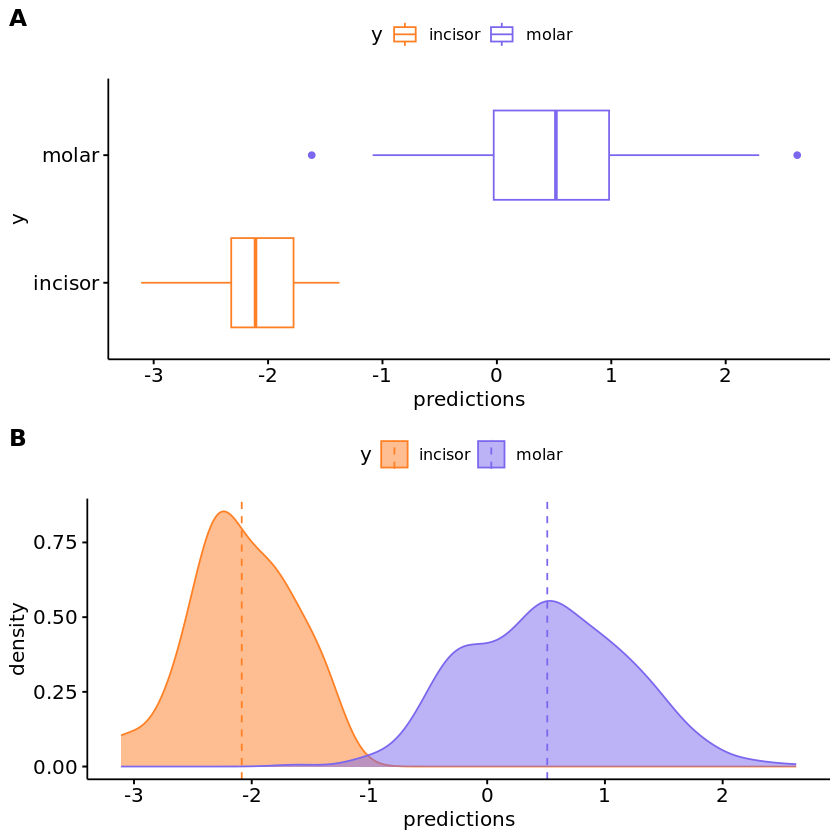

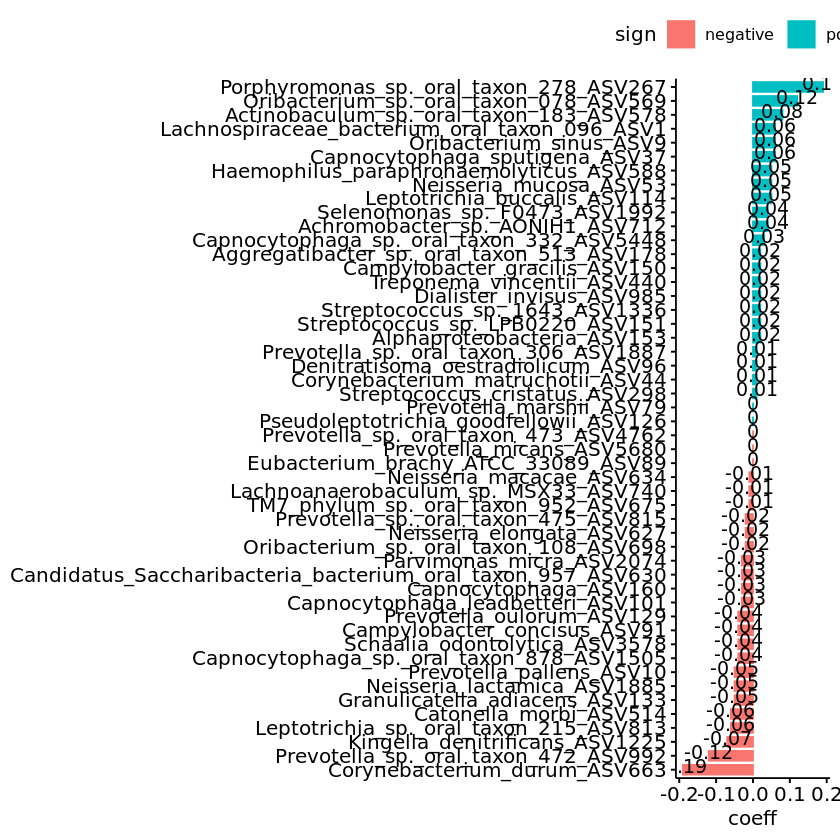

In [21]:
set.seed(852)
bal <- coda_glmnet(x, y)

In [22]:
pdf("balance_incisor_v_molar.HI.pdf")
bal$`predictions plot`
bal$`signature plot`
dev.off()

png 
  2

### HEU

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 272 taxa and 362 samples ]
sample_data() Sample Data:       [ 362 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 272 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 272 tips and 271 internal nodes ]

[1] 362 271

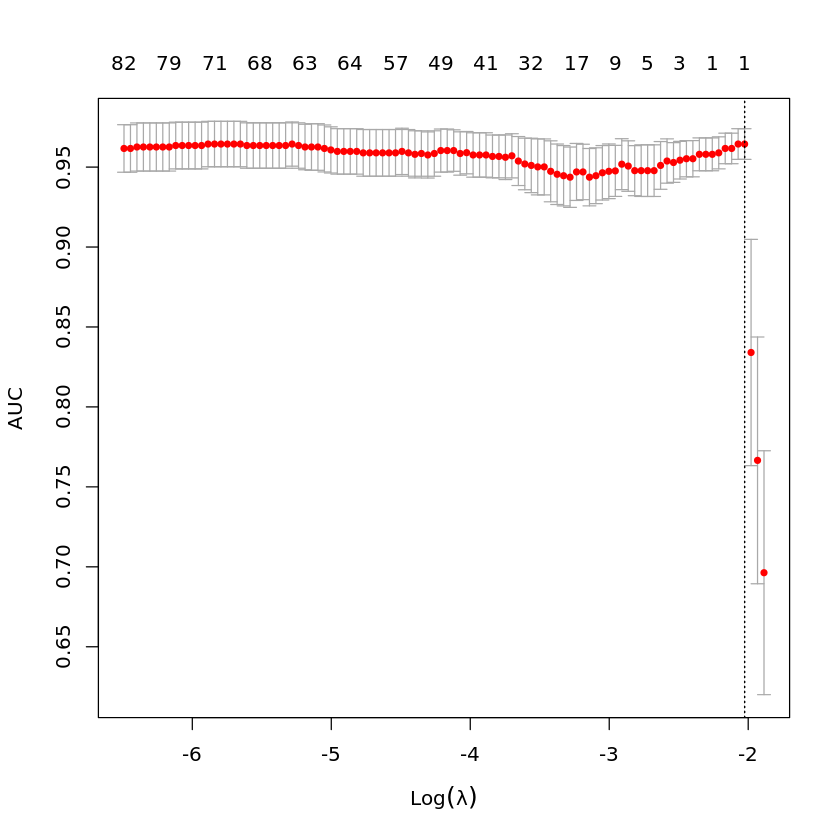

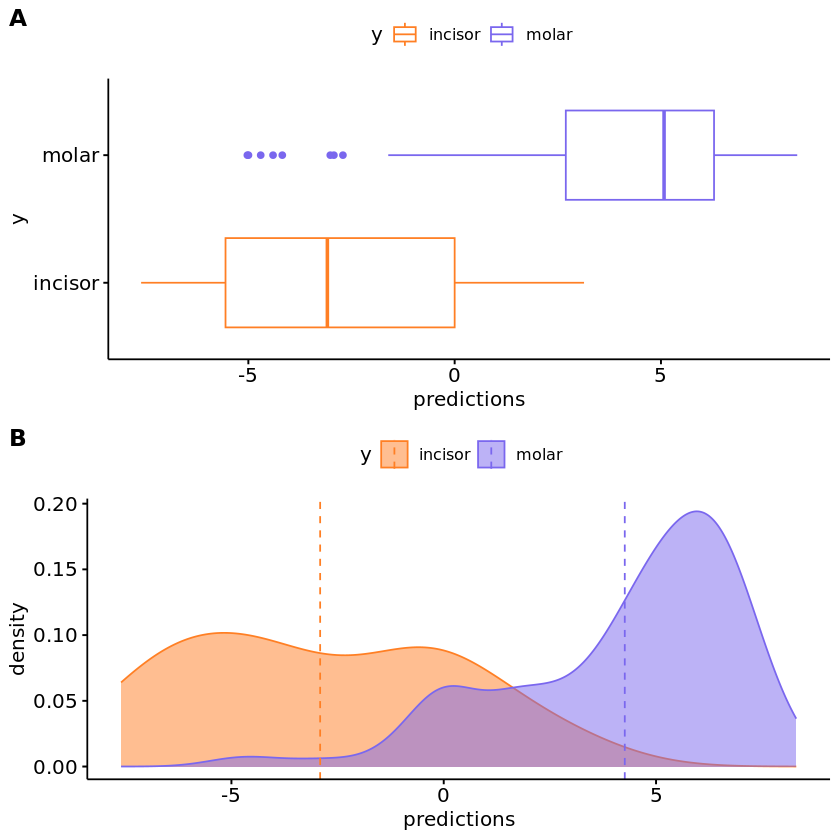

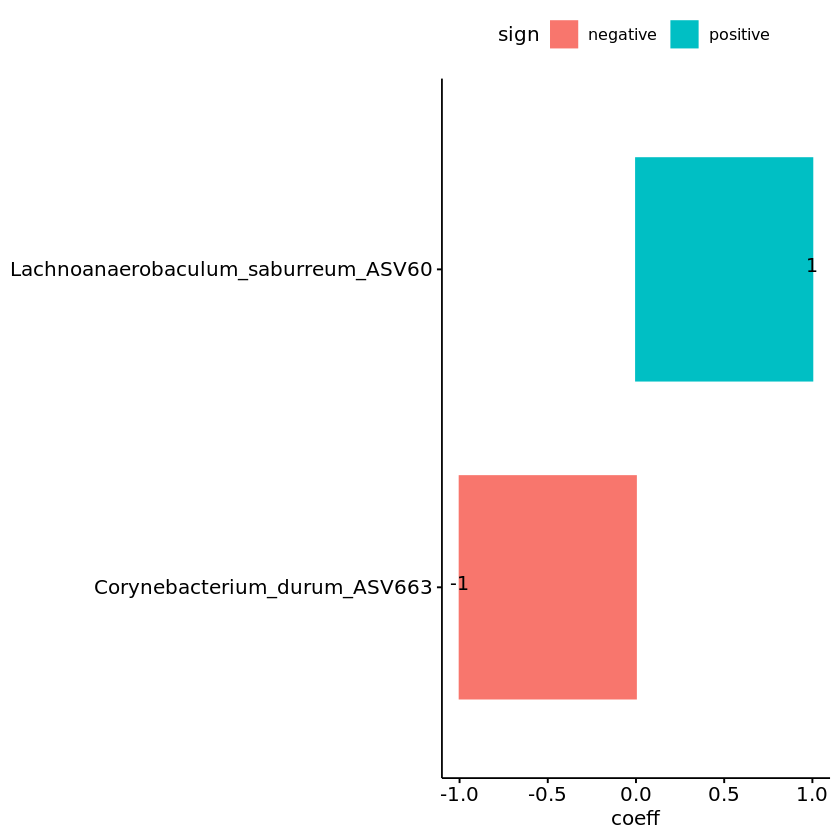

In [23]:
# by HIV status group
glom <- filter_taxa(ps.dat.glom, function(x) sum(x > 10) > (0.05*length(x)), TRUE)
glom <- subset_samples(glom, hiv_status == "HEU")                    
glom
# pull data
dat <- t(as.data.frame(otu_table(glom)))
map <- as.data.frame(as.matrix(sample_data(glom))) # have to coerce to data frame
map <- tibble::rownames_to_column(map) # retain rownames for downstream processing
# get corresponding taxonomy name for each asv
taxa <- as(tax_table(glom), "matrix")
taxadf <- as.data.frame(taxa)
orderdf <- select(taxadf, V8)
orderdf <- orderdf %>%
    rownames_to_column(var = "ASV")
# rename ASV at species level
dat <- as.data.frame(dat)
dat <- dat %>% 
    rownames_to_column(var = "ASV")
dat <- left_join(dat, orderdf, by=c('ASV'='ASV'))  
rownames(dat) <- paste(dat$V8, dat$ASV, sep="_")
dat <- dat[2:(length(dat)-1)] #remove last column
dat <- as.matrix(t(dat))
# merge new metadata with asv table so the response variable is in the same order
datmerge <- merge(dat, map, by.x = "row.names", by.y = "rowname")
datmerge <- datmerge[!duplicated(datmerge[c('Row.names')]), ]
row.names(datmerge) <- datmerge$Row.names
# define data and response variable
dif <- dim(datmerge)[2] - dim(map)[2]
x <- datmerge[,2:dif]
# make sure only numeric data
x <- select_if(x, is.numeric)
dim(x)
# define response variable 
y <- as.factor(datmerge$tooth_type)
set.seed(852)
bal <- coda_glmnet(x, y)

In [24]:
pdf("balance_incisor_v_molar.HEU.pdf")
bal$`predictions plot`
bal$`signature plot`
dev.off()

png 
  2